<a href="https://colab.research.google.com/github/vitesempl/RK-IDE-Julia/blob/master/Julia%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing a **Python** package from **GitHub**

In [1]:
!git clone https://github.com/vitesempl/RK-IDE-Julia/
# move only package to main directory (for activate module by Julia)
!cp -r "$PWD/RK-IDE-Julia/RK" "$PWD/"
# delete unnecessary files
!rm -r RK-IDE-Julia

Cloning into 'RK-IDE-Julia'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 133 (delta 65), reused 61 (delta 21), pack-reused 0
Receiving objects: 100% (133/133), 2.31 MiB | 4.91 MiB/s, done.
Resolving deltas: 100% (65/65), done.


# Installing **Julia** on **Google Colab**


Steps how to run **Julia**:
1.   Run the block below and install Julia Kernel
2.   Аfter installation (message `DONE`) go to notebook settings
3.   Select `Julia 1.6.2` again as runtime



In [2]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.2-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; pkg"add IJulia; add Plots; precompile"' &> /dev/null
!echo "DONE"

DONE


# **Julia Code**

In [1]:
using InteractiveUtils;
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)


## Local Notebook

In [2]:
using Pkg
Pkg.activate("./RK")
using RK

  Activating environment at `/content/RK/Project.toml`
┌ Info: Precompiling RK [7b8691fb-d5bd-47c8-98ff-aba88156f9b3]
└ @ Base loading.jl:1342


In [3]:
using Plots

## Definition of functions for output 

In [4]:
function OutputSolution()
    # Output numerical solution in the end
    nz = length(history(tspan[1]))
    if nz == 1
        println("y(", tspan[2], ") = ", sol[2][end])
    else
        for i = 1 : nz
            println("y", i, "(", tspan[2], ") = ", (sol[2]')[end-nz+i])
        end
    end
end


function OutputConvOrder(; dde=false)
    # Check convergence order of examples
    # "dde=true" - if equation is DDE (with dicrete delays)
    n      = 8
    err    = zeros(n)
    nsteps = zeros(n)

    for steppow = 1:n
        stepsize = (2.0)^(-steppow)
        
        if dde
            sol = ide_solve(idefun,K,delays_int,history,tspan,stepsize,delays)
        else
            sol = ide_solve(idefun,K,delays_int,history,tspan,stepsize)
        end

        err[steppow] = abs(analytic_sol - sol[2][end])
        nsteps[steppow] = stepsize
    end

    println()
    println("Convergence order: ", (log10(err[end-1]) - log10(err[end])) / (log10((2.0)^(-n+1)) - log10((2.0)^(-n))));

    X_ticks = [(10.0)^(-x) for x in 1:15]
    Y_ticks = [(10.0)^(-x) for x in 0:0.5:3]
    display(plot(err, 
                nsteps, 
                linewidth=3, 
                xaxis=:log10, 
                yaxis=:log10, 
                xticks=X_ticks, 
                yticks=Y_ticks, 
                xlabel="ERROR", 
                ylabel="STEPSIZE",
                legend=false, 
                title="Convergence order"))
end

OutputConvOrder (generic function with 1 method)

## Example 1 (only integral)

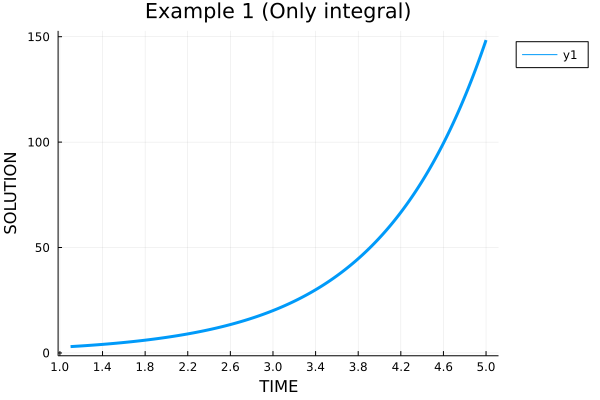

y(5.0) = 148.41315925335257



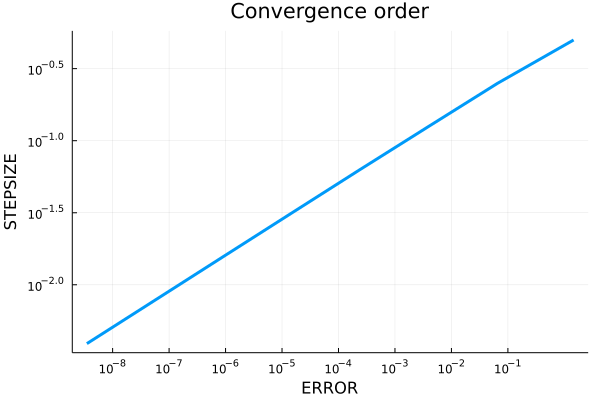

Convergence order: 4.001770395412852


In [5]:
idefun(t,y,z,i) = ((t - 1) * exp(t^2) * i) / (exp(-1) * y[1] - 1)
K(t,s,y)        = y * exp(-s * t)
delays_int(t)   = t - 1  # lower integration limit
history(t)      = exp(t)

tspan = [1.1 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

# Output vector of times t     #print(sol[1])
# Output vector of solutions y #print(sol[2])
OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 1 (Only integral)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
OutputConvOrder() 

## Example 2 (integral+discrete delays)

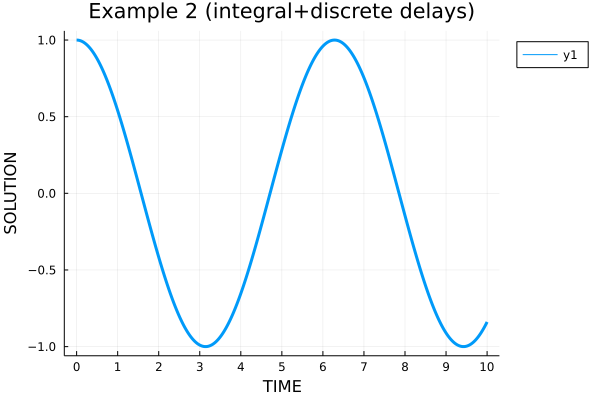

y(10) = -0.8390715237122074



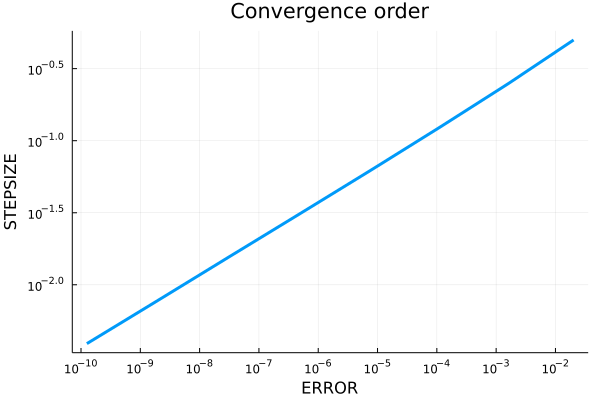

Convergence order: 3.994248239316921


In [6]:
idefun(t,y,z,i) = (1 + exp(-pi / 2)) * y - exp(-pi / 2) * z - 2 * exp(-2 * t) * i
K(t,s,y)        = y * exp(t + s)
delays(t,y)     = t - pi / 2
delays_int(t)   = t - pi / 2
history(t)      = cos(t)

tspan = [0 10]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 2 (integral+discrete delays)", 
            legend=:outertopright))

# Check convergence order
fun(t) = cos(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
OutputConvOrder(dde=true) 

## Example 3 (integral+discrete delays+overlapping)

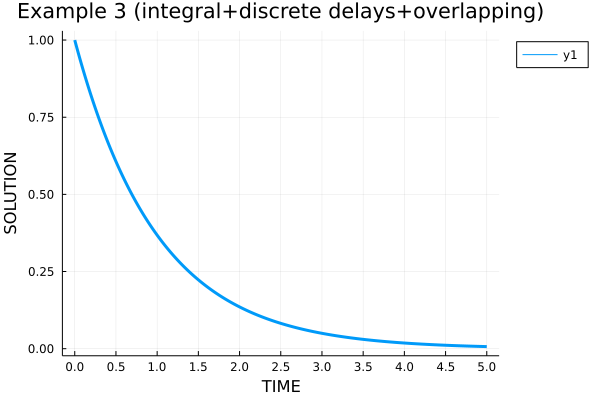

y(5) = 0.006737946981458059



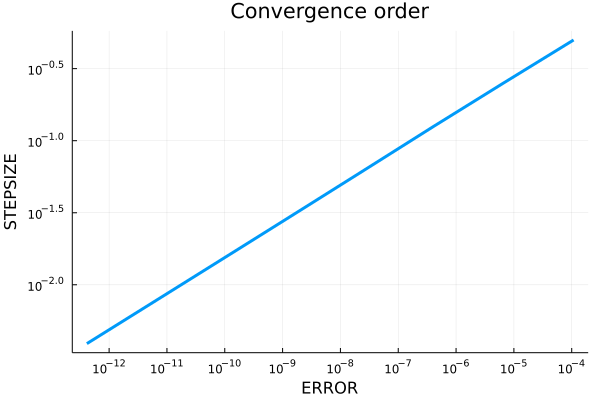

Convergence order: 3.9949091111752955


In [7]:
idefun(t,y,z,i) = -y.^2 - t * exp(t^2) * z^4 * i
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = t / 2
delays_int(t)   = t - 1
history(t)      = exp(-t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 3 (integral+discrete delays+overlapping)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(-t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
OutputConvOrder(dde=true) 

## Example 4 (2 integrals)

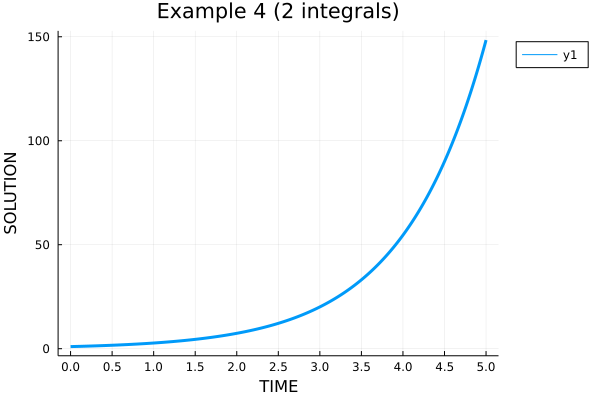

y(5) = 148.41315915325342



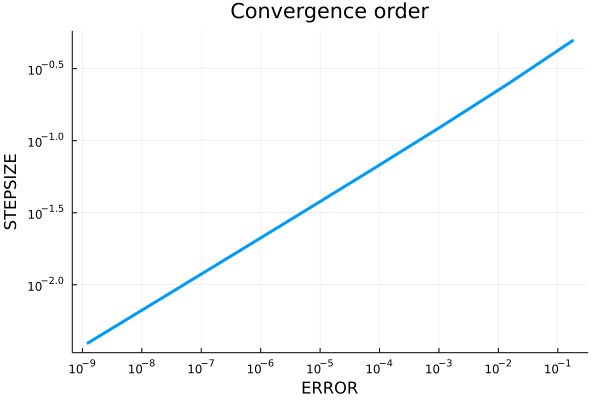

Convergence order: 3.992938268473011


In [8]:
idefun(t,y,z,i) = exp(1) - exp(t^2) / (z[1]^2) * (i[1] - exp(-2 * t) * i[2]) * (t - 1)
K(t,s,y)        = [ y * exp(-s * t);
                    y * exp(t * (2 - s))]
delays(t,y)     = t - 1
delays_int(t)   = [ t - 1;
                    t - 2 ]
history(t)      = exp(t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 4 (2 integrals)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
OutputConvOrder(dde=true) 

## Example 5 (2 discrete delays + *State-dependent*)

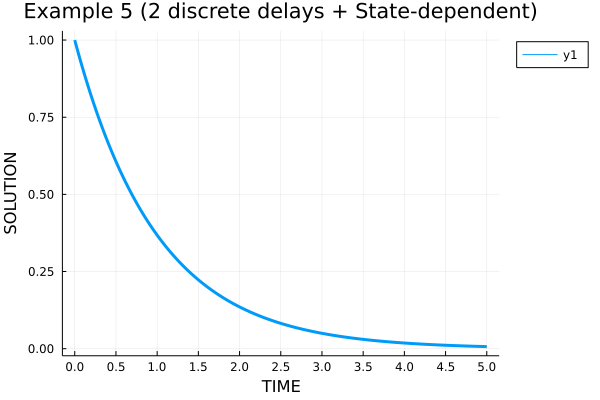

y(5) = 0.006737947029428378



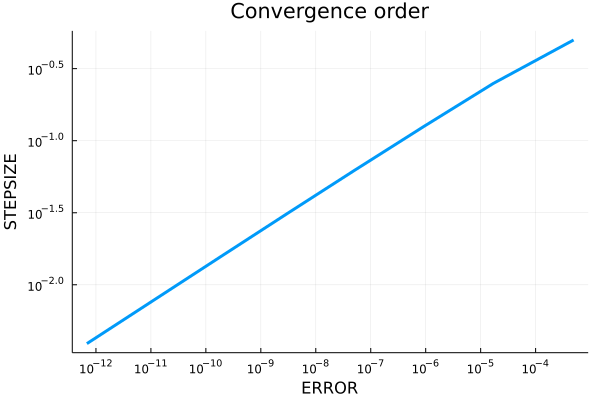

Convergence order: 4.034954918091005


In [9]:
idefun(t,y,z,i) = -z[1]^((t + 1) / 2) * z[2] * y.^2 * (1 + exp(t^2) * t * i[1]) / exp(0.5)
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = [ (log(y[1]))^2 / (t + 1) - 0.5;
                    (t - 1) / 4 ]
delays_int(t)   = t / 2 - 1
history(t)      = exp(-t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 5 (2 discrete delays + State-dependent)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(-t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
OutputConvOrder(dde=true) 

## Example 6 (system of equations)



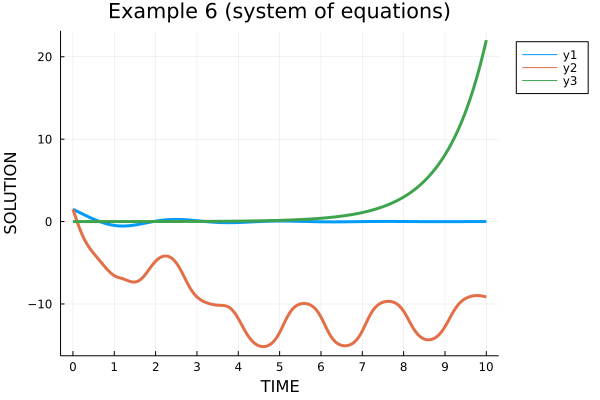

y1(10) = 0.004329876789507738
y2(10) = -9.145191243883074
y3(10) = 22.026465794883663


In [10]:
idefun(t,y,z,i) = [ -2.5 * i[1];
                    -15 * i[2];
                    0.001 * exp(t)]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2])]
delays_int(t)   = [ t - 1;
                    t - 1 ]
history(t)      = [ 1.5;
                    1.5;
                    0.001 * exp(t)]

tspan = [0 10]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 6 (system of equations)", 
            legend=:outertopright))

## Examples (Yukihiko)

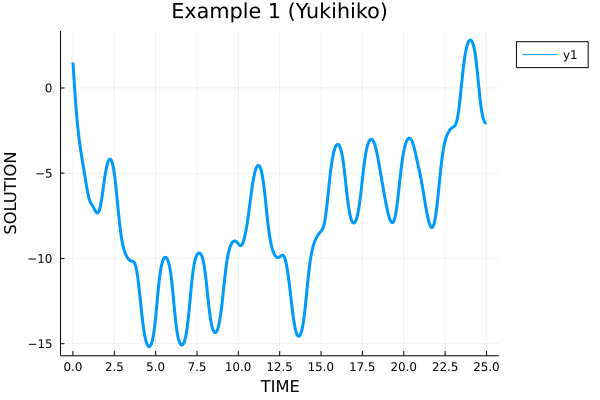

y(25) = -2.0422322798209653


In [11]:
idefun(t,y,z,i) = -15 * i
K(t,s,y)        = sin(y)
delays_int(t)   = t - 1
history(t)      = 1.5

tspan = [0 25]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 1 (Yukihiko)", 
            legend=:outertopright))

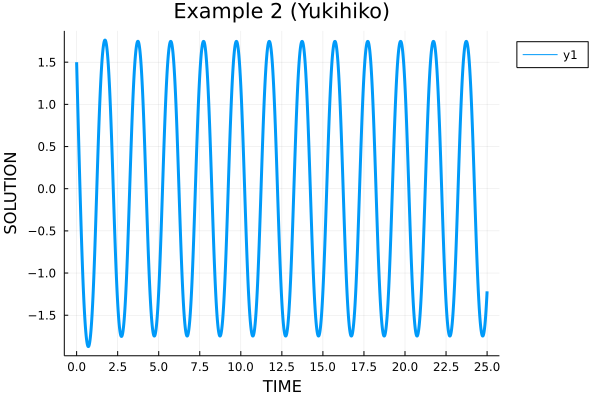

y(25) = -1.216745086566776


In [12]:
idefun(t,y,z,i) = -7.5 * i

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 2 (Yukihiko)", 
            legend=:outertopright))

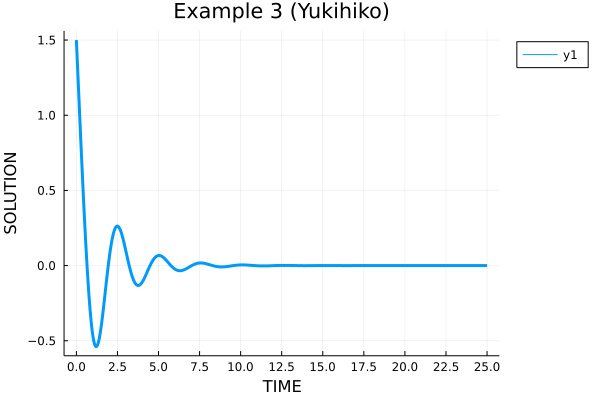

y(25) = 8.176591500707333e-7


In [13]:
idefun(t,y,z,i) = -2.5 * i

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 3 (Yukihiko)", 
            legend=:outertopright))

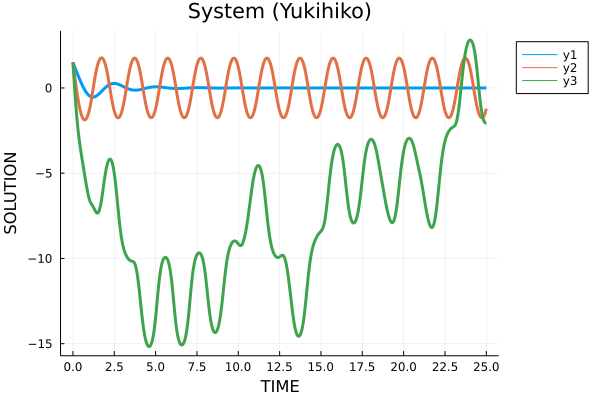

y1(25) = 8.176591500707333e-7
y2(25) = -1.216745086566776
y3(25) = -2.0422322798209653


In [14]:
idefun(t,y,z,i) = [ -2.5*i[1];
                    -7.5*i[2];
                    -15*i[3] ]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2]);
                    sin(y[3]) ]
delays_int(t)   = [ t-1;
                    t-1;
                    t-1 ]
history(t)      = [ 1.5;
                    1.5;
                    1.5 ]

tspan = [0 25]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="System (Yukihiko)", 
            legend=:outertopright))

## Speed test (5 examples)



In [15]:
stepsize = 1e-2;

In [16]:
idefun(t,y,z,i) = ((t - 1) * exp(t^2) * i) / (exp(-1) * y[1] - 1)
K(t,s,y)        = y * exp(-s * t)
delays_int(t)   = t - 1
history(t)      = exp(t)

tspan = [1.1 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

Elapsed time:  1.072592 seconds (3.69 M allocations: 214.690 MiB, 5.61% gc time, 73.35% compilation time)
y(5.0) = 148.41315925335257


In [17]:
idefun(t,y,z,i) = -y.^2 - t * exp(t^2) * z^4 * i
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = t / 2
delays_int(t)   = t - 1
history(t)      = exp(-t)



print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  1.265274 seconds (3.78 M allocations: 219.640 MiB, 5.22% gc time, 74.75% compilation time)
y(5.0) = 0.006737946973021571


In [18]:
idefun(t,y,z,i) = exp(1) - exp(t^2) / (z[1]^2) * (i[1] - exp(-2 * t) * i[2]) * (t - 1)
K(t,s,y)        = [ y * exp(-s * t);
                    y * exp(t * (2 - s))]
delays(t,y)     = t - 1
delays_int(t)   = [ t - 1;
                    t - 2 ]
history(t)      = exp(t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  2.579952 seconds (14.27 M allocations: 799.010 MiB, 6.94% gc time, 53.74% compilation time)
y(5) = 148.41315915325342


In [19]:
idefun(t,y,z,i) = -z[1]^((t + 1) / 2) * z[2] * y.^2 * (1 + exp(t^2) * t * i[1]) / exp(0.5)
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = [ (log(y[1]))^2 / (t + 1) - 0.5;
                    (t - 1) / 4 ]
delays_int(t)   = t / 2 - 1
history(t)      = exp(-t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  2.045706 seconds (10.41 M allocations: 583.286 MiB, 6.48% gc time, 55.19% compilation time)
y(5) = 0.006737947029428378


In [20]:
idefun(t,y,z,i) = [ -2.5 * i[1];
                    -15 * i[2];
                    0.001 * exp(t)]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2])]
delays_int(t)   = [ t - 1;
                    t - 1 ]
history(t)      = [ 1.5;
                    1.5;
                    0.001 * exp(t)]

tspan = [0 10]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

Elapsed time:  3.503006 seconds (20.66 M allocations: 1.312 GiB, 10.42% gc time, 32.08% compilation time)
y1(10) = 0.004329876789507738
y2(10) = -9.145191243883074
y3(10) = 22.026465794883663
